In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns

In [3]:
import sklearn
import os
import shutil
import cv2
import random

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

2024-03-14 17:14:56.498801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 17:14:56.498918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 17:14:56.639292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [6]:
import os
import cv2
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 224

def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        data += [(cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR), (img_size, img_size)), cv2.COLOR_BGR2RGB), class_num) for img in os.listdir(path)]
    return np.array(data, dtype=object)

In [7]:
# Getting the image datasets from paths of the training, test and validation dataset.
train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val')

In [8]:
#Joining the datasets to enable splitting the dataset using the 80:20 ratio
dataset = np.concatenate((train, val, test), axis=0)
len(dataset)
print(dataset.shape)

(5856, 2)


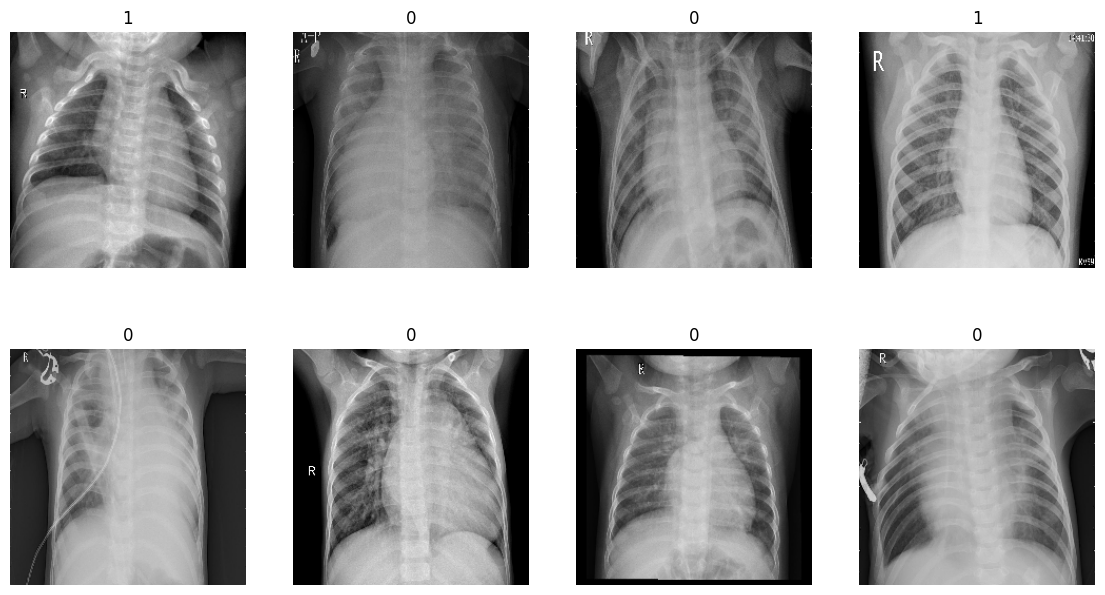

In [9]:
import random
import matplotlib.pyplot as plt

def plot_images_from_folder(dataset):
    random_indices = random.sample(range(len(dataset)), min(len(dataset), 8))
    plt.figure(figsize=(14, 24))
    for i, idx in enumerate(random_indices):
        plt.subplot(6, 4, i + 1)
        plt.imshow(dataset[idx][0], cmap='gray')
        plt.axis('off')
        plt.title(dataset[idx][1])
    plt.show()
    
plot_images_from_folder(dataset)

In [10]:
#Split the dataset into the training and test dataset
initial_train_df, test_df = train_test_split(dataset, test_size = 0.20, random_state = 30)
#Split the training dataset into the training and val dataset
train_df, val_df = train_test_split(initial_train_df, test_size = 0.20, random_state = 30)

Number of labels: 3747
Count of 'pneumonia' (Class 0): 2739
Count of 'normal' (Class 1): 1008


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


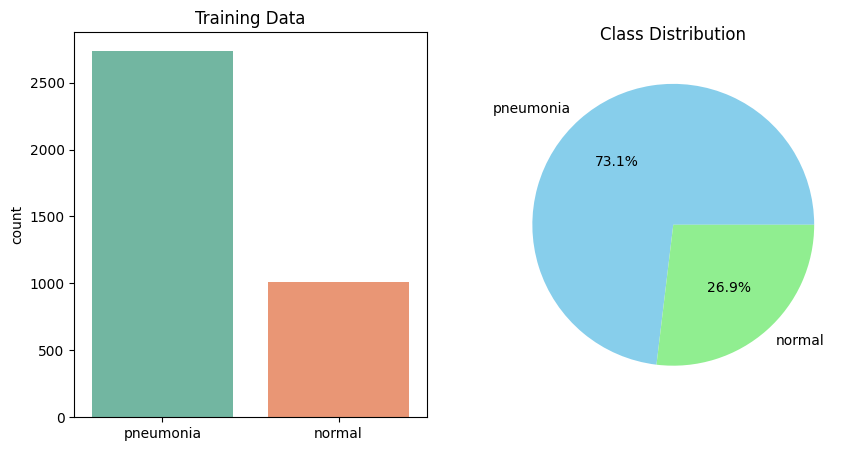

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def count_labels(labels):
    # Extracting labels
    extracted_labels = [data[1] for data in labels]
    
    print("Number of labels:", len(extracted_labels))
    class_counts = np.bincount(extracted_labels)
    print("Count of 'pneumonia' (Class 0):", class_counts[0])
    print("Count of 'normal' (Class 1):", class_counts[1])
    
    # Plotting count distribution
    plt.figure(figsize=(10, 5))
    
    # Count plot
    plt.subplot(1, 2, 1)
    sns.countplot(x=extracted_labels, palette="Set2").set(title="Training Data", xticklabels=['pneumonia', 'normal'])
    
    # Pie chart
    plt.subplot(1, 2, 2)
    labels = ['pneumonia', 'normal']
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
    plt.title('Class Distribution')
    
    plt.show()

# Example usage
count_labels(train_df)


Number of labels: 937
Count of 'pneumonia' (Class 0): 698
Count of 'normal' (Class 1): 239


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


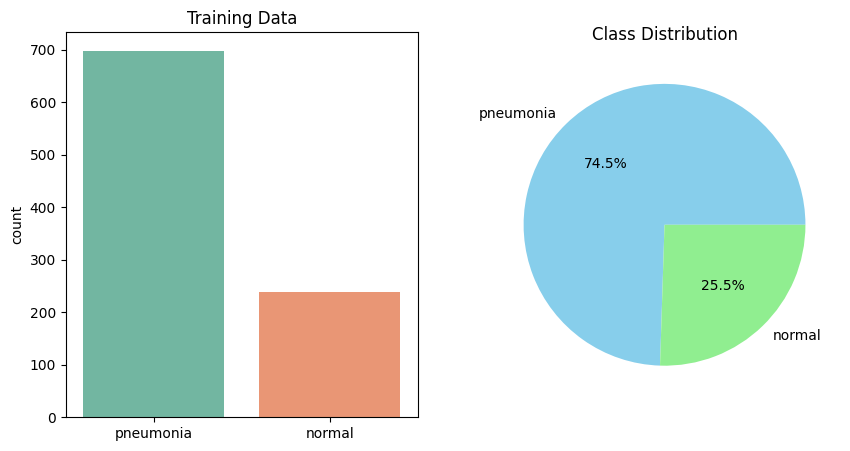

In [12]:
#Class distribution for validation dataset
count_labels(val_df)

Number of labels: 1172
Count of 'pneumonia' (Class 0): 836
Count of 'normal' (Class 1): 336


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


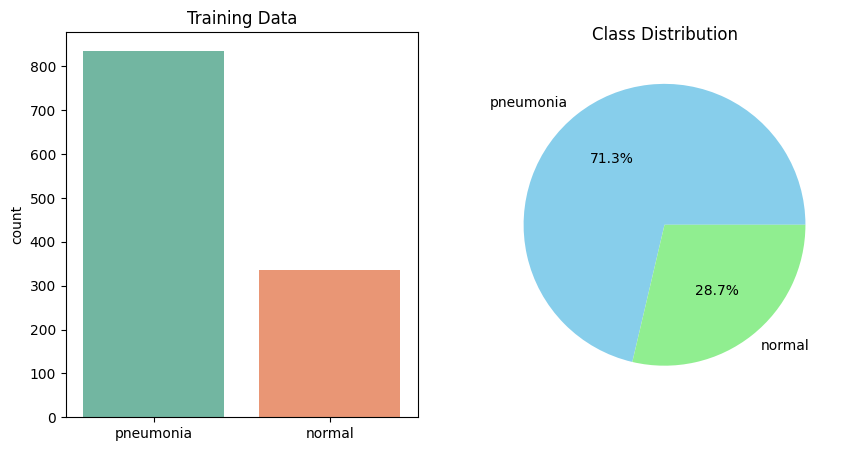

In [13]:
#Class distribution for test dataset
count_labels(test_df)

In [14]:
#Shape of training dataset
train_df.shape

(3747, 2)

In [15]:
#Shape of val dataset
val_df.shape

(937, 2)

In [16]:
#Shape of test dataset
test_df.shape

(1172, 2)

### Seperate the images and labels

In [17]:
x_train, y_train = zip(*train_df)
x_test, y_test = zip(*test_df)
x_val, y_val = zip(*val_df)

In [18]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [19]:
# reshape data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [20]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [21]:
# Define the early stopping and learning rate reduction callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3)

# VGG 16 Model

In [22]:
# VGG 16 Model
# Loading the model
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

# Making sure the layers of the VGG16 model are not retrained 
for layer in vgg16_base_model.layers:
    layer.trainable = False

In [23]:
vgg16_model = tf.keras.models.Sequential()
vgg16_model.add(vgg16_base_model)
vgg16_model.add(tf.keras.layers.Flatten())
vgg16_model.add(tf.keras.layers.BatchNormalization())
vgg16_model.add(tf.keras.layers.Dense(128, activation='relu'))
vgg16_model.add(tf.keras.layers.Dropout(0.5))
vgg16_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
vgg16_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [24]:
# Train the vgg16 model with early stopping
vgg16_model_history = vgg16_model.fit(
    datagen.flow(x_train,y_train, batch_size=32),
    epochs=5,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-14 17:17:10.922141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-03-14 17:17:10.922206: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-03-14 17:17:10.922223: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-03-14 17:17:10.922237: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-03-14 17:17:10.922252: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

  2/118 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.6172 - loss: 0.6967  

I0000 00:00:1710436647.540048     820 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  7/118 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - accuracy: 0.7160 - loss: 0.7747

2024-03-14 17:17:30.118987: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.54907, expected 2.92871
2024-03-14 17:17:30.119045: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.96556, expected 4.3452
2024-03-14 17:17:30.119065: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.02093, expected 4.40057
2024-03-14 17:17:30.119081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.88945, expected 4.26909
2024-03-14 17:17:30.119093: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.14523, expected 4.52487
2024-03-14 17:17:30.119104: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.19105, expected 3.57069
2024-03-14 17:17:30.119116: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 3.8535, expected 3.23314
2024-03-14 17:17:30.119127: E external/local_xla/xla/serv

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8409 - loss: 0.9836

2024-03-14 17:18:14.337871: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.40131, expected 2.00221
2024-03-14 17:18:14.337943: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 2.97198, expected 2.57289
2024-03-14 17:18:14.337957: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.88224, expected 2.48315
2024-03-14 17:18:14.338007: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5824: 2.95102, expected 2.55192
2024-03-14 17:18:14.338261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50092: 2.95205, expected 2.55296
2024-03-14 17:18:14.338694: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 4.55134, expected 3.66346
2024-03-14 17:18:14.338735: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.08774, expected 5.19985
2024-03-14 17:18:14.338752: E exte

118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 444ms/step - accuracy: 0.8412 - loss: 0.9818 - val_accuracy: 0.7449 - val_loss: 15.1540 - learning_rate: 0.0010
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 44s 352ms/step - accuracy: 0.9051 - loss: 0.4110 - val_accuracy: 0.7396 - val_loss: 14.7638 - learning_rate: 0.0010
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 44s 358ms/step - accuracy: 0.8962 - loss: 0.3591 - val_accuracy: 0.7449 - val_loss: 10.5448 - learning_rate: 0.0010
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 44s 354ms/step - accuracy: 0.9211 - loss: 0.6966 - val_accuracy: 0.7449 - val_loss: 4.9597 - learning_rate: 0.0010
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 44s 355ms/step - accuracy: 0.9258 - loss: 0.2101 - val_accuracy: 0.7449 - val_loss: 7.4744 - learning_rate: 0.0010


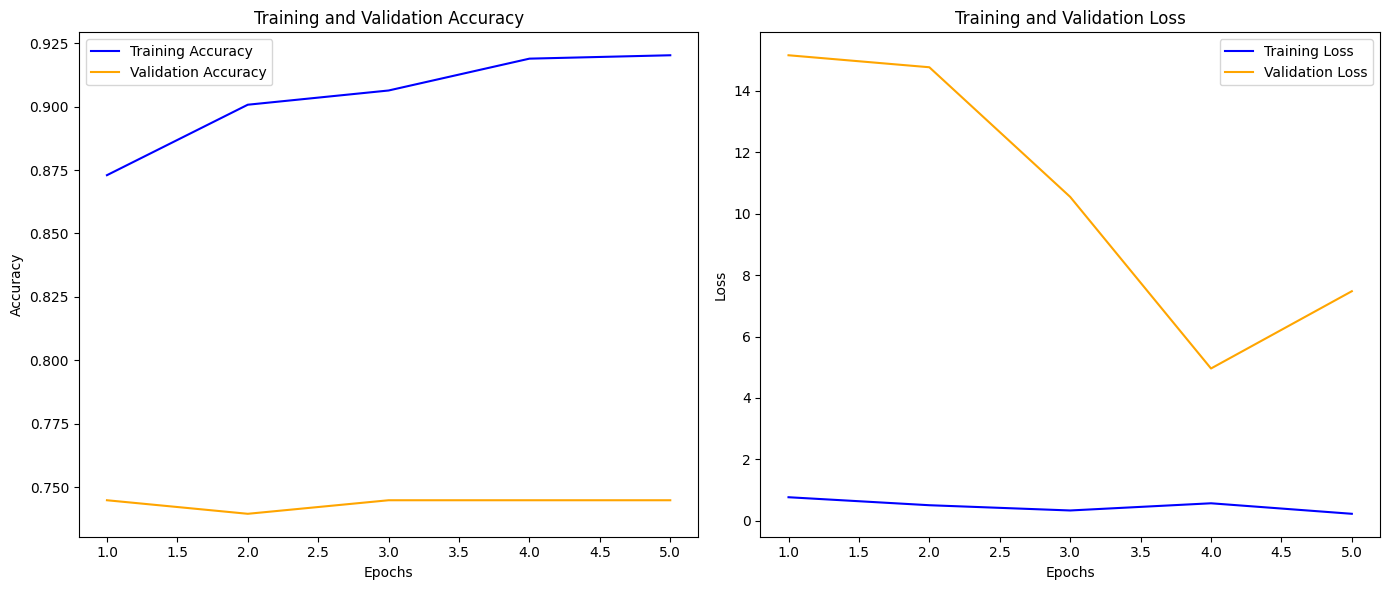

In [25]:
# Plotting the VGG16 model results

# Getting the accuracy
acc = vgg16_model_history.history['accuracy']
val_acc = vgg16_model_history.history['val_accuracy']
  
# Getting the losses
loss = vgg16_model_history.history['loss']
val_loss = vgg16_model_history.history['val_loss']

# Number of epochs it trained
epochs_range = range(1, len(acc) + 1)

# Plotting Training and Validation accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Vgg16 Performance Evaluation

In [26]:
evaluation_result=vgg16_model.evaluate(x_test,y_test)

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7158 - loss: 4.1924

2024-03-14 17:21:21.134265: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.79983, expected 3.15789
2024-03-14 17:21:21.134337: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.13466, expected 4.49272
2024-03-14 17:21:21.134354: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.78155, expected 4.13961
2024-03-14 17:21:21.134372: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.88295, expected 4.24101
2024-03-14 17:21:21.134386: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.73279, expected 4.09085
2024-03-14 17:21:21.134397: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.69943, expected 4.05749
2024-03-14 17:21:21.134408: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.1975, expected 3.55556
2024-03-14 17:21:21.134421: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 379ms/step - accuracy: 0.7157 - loss: 4.1932


In [27]:
print("Loss of the model is - " , evaluation_result[0])
print("Accuracy of the model is - " , evaluation_result[1]*100 , "%")

Loss of the model is -  4.20750617980957
Accuracy of the model is -  71.33105993270874 %


In [28]:
vgg16_predictions = vgg16_model.predict(x_test)
y_pred = (vgg16_predictions> 0.5).astype("int32").flatten()
y_pred

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [29]:
#Classification report
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (0)','Normal (1)']))

               precision    recall  f1-score   support

Pneumonia (0)       0.71      1.00      0.83       836
   Normal (1)       0.00      0.00      0.00       336

     accuracy                           0.71      1172
    macro avg       0.36      0.50      0.42      1172
 weighted avg       0.51      0.71      0.59      1172



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[836   0]
 [336   0]]


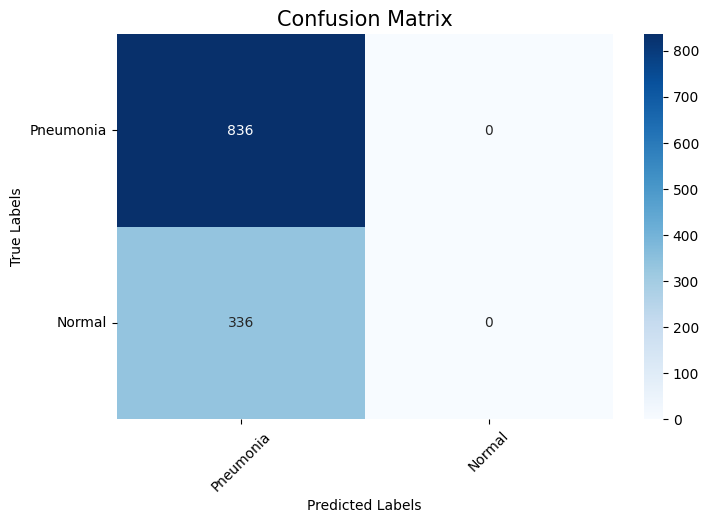

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Setting the labels
labels = ['Pneumonia', 'Normal']

# Plotting the confusion matrix graph
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels', fontsize=10)
plt.ylabel('True Labels', fontsize=10)
plt.title('Confusion Matrix', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## If you find this notebook helpful, please **upvote**. Your support will be highly appreciated!.
